In [165]:
import simpy
import random

In [166]:
hours=8
days=20
total_time=hours*days
cloth_capacity=300
initial_cloth=100
accessory_capacity=200
initial_accessory=80
pre_sew_capacity=100
post_sew_capacity=200
dispatch_capacity=400

In [167]:
num_fabric=3
mean_fabric=1
std_fabric=0.1

num_lining=2
mean_lining=1
std_lining=0.1

num_sew=2
mean_sew=3
std_sew=0.2

num_assemble=4
mean_assemble=2
std_assemble=0.2

In [168]:
cloth_critical_stock=(((8/mean_fabric)*num_fabric+(8/mean_lining)*num_lining)*3)
accessory_critical_stock=(8/mean_assemble)*num_assemble*2

In [169]:
class Overcoat_Factory:
    def __init__(self,env):
        self.cloth=simpy.Container(env, capacity=cloth_capacity, init= initial_cloth)
        self.cloth_control=env.process(self.cloth_stock_control(env))
        self.accessory=simpy.Container(env, capacity=accessory_capacity, init= initial_accessory)
        self.accessory_control=env.process(self.accessory_stock_control(env))
        self.pre_sew=simpy.Container(env, capacity=pre_sew_capacity, init=0)
        self.post_sew=simpy.Container(env, capacity=post_sew_capacity, init=0)
        self.dispatch=simpy.Container(env, capacity=dispatch_capacity, init=0)
        
    def cloth_stock_control(self, env):
        yield env.timeout(0)
        while True:
            if self.cloth.level<=cloth_critical_stock:
                print('cloth stock bellow ccritical level ({0}) at day {1}, hour{2}'.format(self.cloth.level, int(env.now/8), env.now % 8))
                print('need cloth supplier')
                print('--------------------')
                yield env.timeout(16)
                print('cloth supplier arrives at day{0},hour {1}'.format(int(env.now/8), env.now % 8))
                yield self.cloth.put(300)
                print('new cloth stock is {0}'.format(self.cloth.level))
                print('--------------------')
                yield env.timeout(8)
            else:
                yield env.timeout(1)
    
    def accessory_stock_control(self, env):
        yield env.timeout(0)
        while True:
            if self.accessory.level<=accessory_critical_stock:
                print('accessory stock bellow critical level({0}) at day {1}, hour{2}'.format(self.accessory.level, int(env.now/8), env.now%8))
                print('need accessory supplier')
                print('-----------------------')
                yield env.timeout(9)
                print('accessory supplier arrive at day {0}, hour{1}'.format(int(env.now/8), env.now %8))
                yield self.accessory.put(50)
                print('new accessory stock is {0}'.format(self.accessory.level))
                print('-----------------------')
                yield env.timeout(8)
            else:
                yield env.timeout(1)
        

In [170]:
def fabric_maker(env, overcoat_factory):
    while True:
        yield overcoat_factory.cloth.get(1)
        fabric_time=random.gauss(mean_fabric, std_fabric)
        yield env.timeout(fabric_time)
        yield overcoat_factory.pre_sew.put(3)

In [171]:
def lining_maker(env, overcoat_factory):
    while True:
        yield overcoat_factory.cloth.get(1)
        lining_time=random.gauss(mean_lining, std_lining)
        yield env.timeout(lining_time)
        yield overcoat_factory.pre_sew.put(2)

In [172]:
def sewer(env, overcoat_factory):
    while True:
        yield overcoat_factory.cloth.get(10)
        sew_time=random.gauss(mean_sew, std_sew)
        yield env.timeout(sew_time)
        yield overcoat_factory.post_sew.put(10)

In [173]:
def assembler(env, overcoat_factory):
    while True:
        yield overcoat_factory.post_sew.get(1)
        yield overcoat_factory.accessory.get(1)
        assembling_time=max(random.gauss(mean_assemble, std_assemble),1)
        yield env.timeout(assembling_time)
        yield overcoat_factory.dispatch.put(1)

In [174]:
def fabric_maker_gen(env, overcoat_factory):
    for i in range(num_fabric):
        env.process(fabric_maker(env, overcoat_factory))
        yield env.timeout(0)
        
def lining_maker_gen(env, overcoat_factory):
    for i in range(num_lining):
        env.process(lining_maker(env, overcoat_factory))
        yield env.timeout(0)

def sewer_maker_gen(env, overcoat_factory):
    for i in range(num_sew):
        env.process(sewer(env, overcoat_factory))
        yield env.timeout(0)
        
def assembler_maker_gen(env, overcoat_factory):
    for i in range(num_assemble):
        env.process(assembler(env, overcoat_factory))
        yield env.timeout(0)

In [175]:
env = simpy.Environment()
overcoat_factory = Overcoat_Factory(env)

In [176]:
fabric_gen = env.process(fabric_maker_gen(env, overcoat_factory))
lining_gen = env.process(lining_maker_gen(env, overcoat_factory))
sewer_gen = env.process(sewer_maker_gen(env, overcoat_factory))
assembler_gen = env.process(assembler_maker_gen(env, overcoat_factory))

In [177]:
env.run(until = total_time)

print('Pre paint has %d fabric and lining ready to be painted' % overcoat_factory.pre_sew.level)
print('Post paint has %d fabric and lining ready to be assembled' % overcoat_factory.post_sew.level)
print('Dispatch has %d overcoat ready to go!' % overcoat_factory.dispatch.level)
print('----------------------------------')
print('SIMULATION COMPLETED')

cloth stock bellow ccritical level (88) at day 0, hour0
need cloth supplier
--------------------
cloth supplier arrives at day2,hour 0
new cloth stock is 277
--------------------
accessory stock bellow critical level(31) at day 3, hour2
need accessory supplier
-----------------------
accessory supplier arrive at day 4, hour3
new accessory stock is 62
-----------------------
cloth stock bellow ccritical level (117) at day 5, hour1
need cloth supplier
--------------------
accessory stock bellow critical level(30) at day 6, hour3
need accessory supplier
-----------------------
cloth supplier arrives at day7,hour 1
accessory supplier arrive at day 7, hour4
new accessory stock is 61
-----------------------
accessory stock bellow critical level(32) at day 9, hour3
need accessory supplier
-----------------------
accessory supplier arrive at day 10, hour4
new accessory stock is 63
-----------------------
accessory stock bellow critical level(32) at day 12, hour4
need accessory supplier
-------

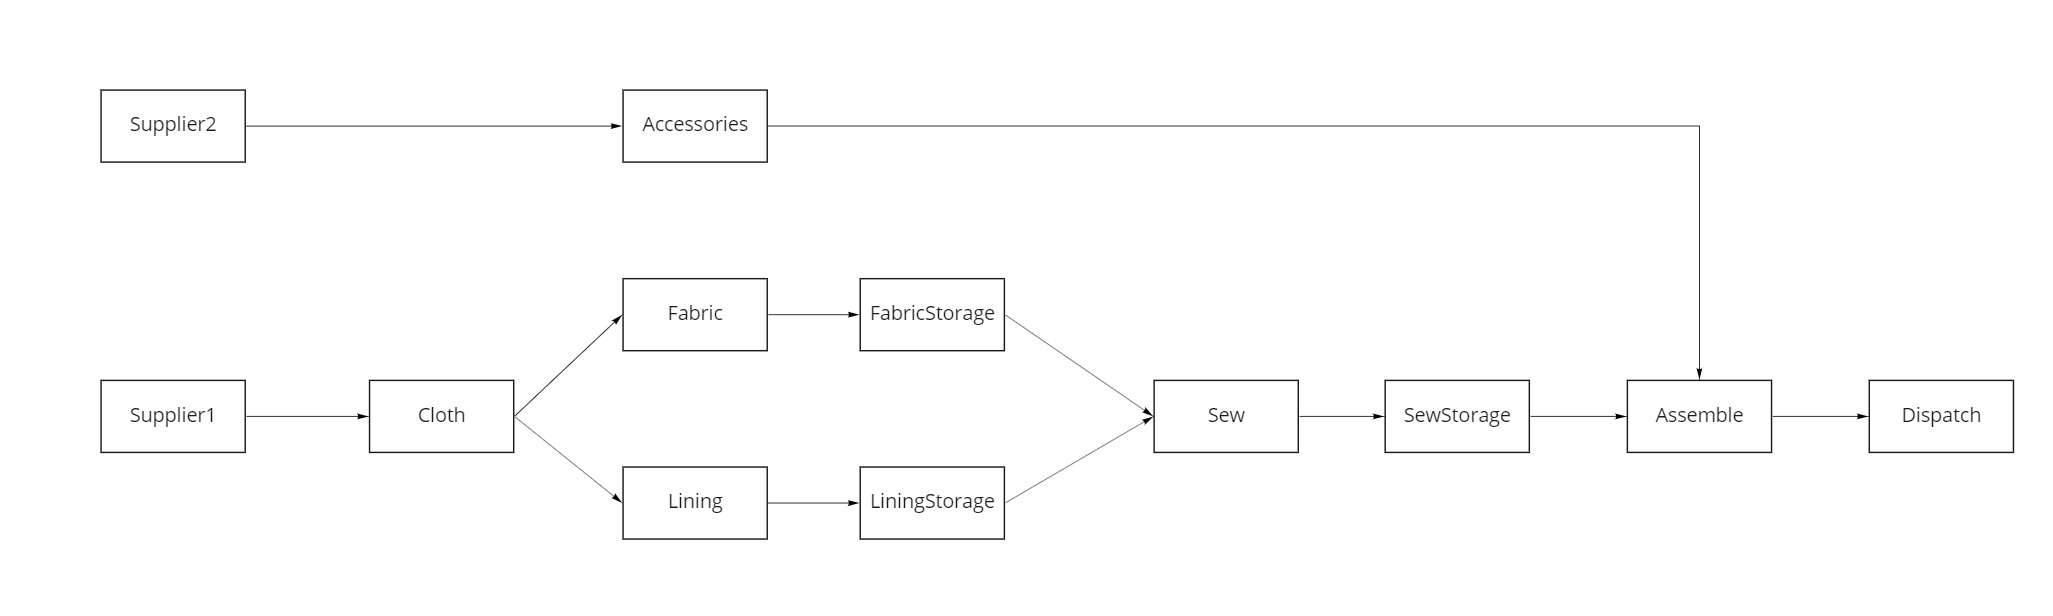